# Think Bayes: Chapter 3

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [2]:
from __future__ import print_function, division

% matplotlib inline

import thinkplot
from thinkbayes2 import Hist, Pmf, Suite, Cdf

## The Dice problem

Suppose I have a box of dice that contains a 4-sided die, a 6-sided
die, an 8-sided die, a 12-sided die, and a 20-sided die.

Suppose I select a die from the box at random, roll it, and get a 6.
What is the probability that I rolled each die?

The `Dice` class inherits `Update` and provides `Likelihood`

In [3]:
class Dice(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1/hypo

Here's what the update looks like:

In [4]:
suite = Dice([4, 6, 8, 12, 20])
suite.Update(6)
suite.Print()

4 0.0
6 0.392156862745
8 0.294117647059
12 0.196078431373
20 0.117647058824


And here's what it looks like after more data:

In [5]:
for roll in [6, 8, 7, 7, 5, 4]:
        suite.Update(roll)
        
suite.Print()

4 0.0
6 0.0
8 0.943248453672
12 0.0552061280613
20 0.0015454182665


## The train problem

The Train problem has the same likelihood as the Dice problem.

In [6]:
class Train(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1/hypo

But there are many more hypotheses

In [7]:
hypos = xrange(1, 1001)
suite = Train(hypos)
suite.Update(60)

0.0028222671142652746

Here's what the posterior looks like

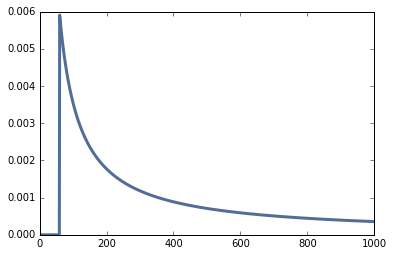

In [8]:
thinkplot.Pdf(suite)

And here's how we can compute the posterior mean

In [9]:
def Mean(suite):
    total = 0
    for hypo, prob in suite.Items():
        total += hypo * prob
    return total

Mean(suite)

333.41989326371095

Or we can just use the method

In [10]:
suite.Mean()

333.41989326371095

## Sensitivity to the prior

Here's a function that solves the train problem for different priors and data

In [11]:
def MakePosterior(high, dataset, constructor=Train):
    """Solves the train problem.
    
    high: int maximum number of trains
    dataset: sequence of observed train numbers
    constructor: function used to construct the Train object
    
    returns: Train object representing the posterior suite
    """
    hypos = range(1, high+1)
    suite = constructor(hypos)

    for data in dataset:
        suite.Update(data)

    return suite

Let's run it with the same dataset and several uniform priors

In [12]:
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    suite = MakePosterior(high, dataset)
    print(high, suite.Mean())

500 151.849587959
1000 164.305586423
2000 171.338181092


The results are quite sensitive to the prior, even with several observations.

## Power law prior

Now let's try it with a power law prior.

In [13]:
class Train2(Train):

    def __init__(self, hypos, alpha=1.0):
        Pmf.__init__(self)
        for hypo in hypos:
            self[hypo] = hypo**(-alpha)
        self.Normalize()

Here's what a power law prior looks like, compared to a uniform prior

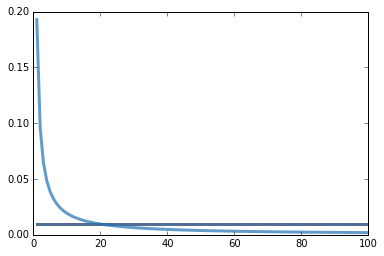

In [14]:
high = 100
hypos = range(1, high+1)
suite1 = Train(hypos)
suite2 = Train2(hypos)
thinkplot.Pdf(suite1)
thinkplot.Pdf(suite2)


Now let's see what the posteriors look like after observing one train.

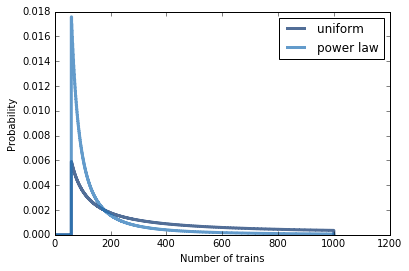

In [15]:
dataset = [60]
high = 1000

thinkplot.PrePlot(num=2)

constructors = [Train, Train2]
labels = ['uniform', 'power law']

for constructor, label in zip(constructors, labels):
    suite = MakePosterior(high, dataset, constructor)
    suite.label = label
    thinkplot.Pmf(suite)

thinkplot.Config(xlabel='Number of trains',
                 ylabel='Probability')

The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.

In [16]:
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    suite = MakePosterior(high, dataset, Train2)
    print(high, suite.Mean())

500 130.708469863
1000 133.275231375
2000 133.997463081


## Credible intervals

To compute credible intervals, we can use the `Percentile` method on the posterior.

In [17]:
hypos = xrange(1, 1001)
suite = Train(hypos)
suite.Update(60)

suite.Percentile(5), suite.Percentile(95)

(69, 869)

If you have to compute more than a few percentiles, it is more efficient to compute a CDF.

Also, a CDF can be a better way to visualize distributions.

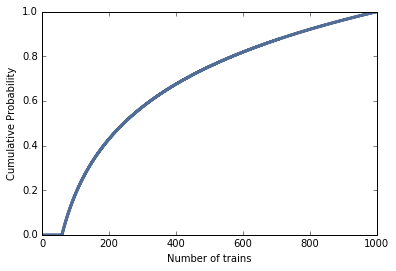

In [18]:
cdf = Cdf(suite)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Number of trains',
                 ylabel='Cumulative Probability',
                 legend=False)

`Cdf` also provides `Percentile`

In [19]:
cdf.Percentile(5), cdf.Percentile(95)

(69, 869)

## Exercises

**Exercise:** To write a likelihood function for the locomotive problem, we had
to answer this question:  "If the railroad has `N` locomotives, what
is the probability that we see number 60?"

The answer depends on what sampling process we use when we observe the
locomotive.  In this chapter, I resolved the ambiguity by specifying
that there is only one train-operating company (or only one that we
care about).

But suppose instead that there are many companies with different
numbers of trains.  And suppose that you are equally likely to see any
train operated by any company.
In that case, the likelihood function is different because you
are more likely to see a train operated by a large company.

As an exercise, implement the likelihood function for this variation
of the locomotive problem, and compare the results.

In [20]:
def permutations(iterable, r=None):
    # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = range(n)
    cycles = range(n, n-r, -1)
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return
class TrainTwo(Suite):
    #given hypo is a list of the number of locomotives of N companies, with 
    # a constriant that each company can have no more than some amount of 
    # trains 
    def __init__(self, n, high):
        """Initialize self.

        hypos: sequence of string bowl IDs
        """
        Pmf.__init__(self)
        hypos = []
        for i in xrange(0, n):
            new_list = random.sample(range(1, high), n)
            hypos.append(new_list)
            
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()


    
    def Likelihood(self, data, hypo):
        print(hypo)
        num_pass = 0
        for h in hypo:
            if h >= data:
                num_pass = num_pass + 1 
        return num_pass/len(hypo) 
    

suite = TrainTwo(hypos, 10, 60)
suite.Update(60)

suite.Print()            
            

TypeError: __init__() takes exactly 3 arguments (4 given)

**Exercise:** Suppose I capture and tag 10 rock hyraxes.  Some time later, I capture another 10 hyraxes and find that two of them are already tagged.  How many hyraxes are there in this environment?

As always with problems like this, we have to make some modeling assumptions. 

1) For simplicity, you can assume that the environment is reasonably isolated, so the number of hyraxes does not change between observations.

2) And you can assume that each hyrax is equally likely to be captured during each phase of the experiment, regardless of whether it has been tagged.  In reality, it is possible that tagged animals would avoid traps in the future, or possible that the same behavior that got them caught the first time makes them more likely to be caught again.  But let's start simple.

I suggest the following notation:

*  `N`: total population of hyraxes 
*  `K`: number of hyraxes tagged in the first round 
*  `n`: number of hyraxes caught in the second round
*  `k`: number of hyraxes in the second round that had been tagged

So `N` is the hypothesis and `(K, n, k)` make up the data.  The probability of the data, given the hypothesis, is the probability of finding `k` tagged hyraxes out of `n` if (in the population) `K` out of `N` are tagged. 

If you are familiar with the hypergeometric distribution, you can use the hypergeometric PMF to compute the likelihood function.  Otherwise, you can figure it out using combinatorics.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here